In [ ]:
import re
import sys
import numpy as np
import gzip
import json
import itertools
from collections import defaultdict

import nltk
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')

WORKING_DIR = 'drive/MyDrive/dtsa5800_tweets_network_analysis'
DATA_DIR = f'{WORKING_DIR}/data'
DATA_FILE = f'{DATA_DIR}/nikelululemonadidas_tweets.jsonl.gz'

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Semantic Network Graph

In [ ]:
brands = ['nike', 'adidas', 'lululemon']
tweets = {}

with gzip.open(DATA_FILE, 'r') as f:
    for line in f:
        tweet = json.loads(line)
        tweet_id = tweet.get('id', None)
        if tweet_id is None:
            continue
        text = tweet.get('full_text') or tweet.get('text', '')
        if any(brand in text.lower() for brand in brands):
            tweets[str(tweet_id)] = text

print(len(tweets))

163285


In [ ]:
def get_wordnet_pos(tag):
    WN = nltk.corpus.wordnet
    if tag.startswith('J'):
        return WN.ADJ
    elif tag.startswith('V'):
        return WN.VERB
    elif tag.startswith('N'):
        return WN.NOUN
    elif tag.startswith('R'):
        return WN.ADV
    else:
        return None


def obtain_tokens(text, add_stopwords=None, min_length=3, remove_mentions=False, remove_hashtags=False):

    STOPWORDS = set(nltk.corpus.stopwords.words('english')).union(add_stopwords)
    LEMMATIZER = nltk.stem.WordNetLemmatizer()
    TTOKENIZER = nltk.tokenize.TweetTokenizer()

    tokens = TTOKENIZER.tokenize(text.lower())
    tokens = [t for t in tokens if not t.startswith(("http://", "https://"))]
    if remove_mentions:
        tokens = [t for t in tokens if '@' not in t]
    if remove_hashtags:
        tokens = [t for t in tokens if '#' not in t]

    processed_tokens = []
    for token in tokens:
        sub_tokens = re.findall(r'[a-zA-Z]+', token)
        tagged = nltk.pos_tag(sub_tokens)
        for token, tag in tagged:
            wntag = get_wordnet_pos(tag)
            if wntag is None:
                lem_token = LEMMATIZER.lemmatize(token)
            else:
                lem_token = LEMMATIZER.lemmatize(token, pos=wntag)
            if lem_token not in STOPWORDS and len(lem_token) >= min_length:
                processed_tokens.append(lem_token)

    return processed_tokens


def process_texts(tweets, brands, add_sws=None,
                  remove_mentions=False, remove_hashtags=False,
                  num_top_words=None, upper_thr=88, lower_thr=1):

    processed_tweets = {}
    word_counts = defaultdict(int)
    for tweet_id, text in tweets.items():
        tokens = obtain_tokens(text, add_sws, remove_mentions, remove_hashtags)
        processed_tweets[tweet_id] = tokens
        for word in tokens:
            word_counts[word] += 1

    upper_limit = np.percentile(list(word_counts.values()), upper_thr)
    lower_limit = np.percentile(list(word_counts.values()), lower_thr)

    sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    filtered_words = [w for w, count in sorted_counts if lower_limit < count < upper_limit or w in brands]
    selected_words = filtered_words if num_top_words is None else filtered_words[:num_top_words]

    return processed_tweets, selected_words


In [ ]:
def build_graph(processed_tokens_dict, selected_words):
    graph = nx.Graph()
    for tweet_id, tokens in processed_tokens_dict.items():
        nodes = [t for t in tokens if t in selected_words]
        cooccurrences = itertools.combinations(nodes, 2)
        graph.add_edges_from(cooccurrences)

    nodes = graph.number_of_nodes()
    edges = graph.number_of_edges()
    print(f"Graph has {nodes} nodes and {edges} edges.")
    return graph

def draw_network_graph(graph, figsize=(20, 15), node_size=800):
    pos = nx.spring_layout(graph, k=0.15, iterations=20)
    plt.figure(figsize=figsize)
    nx.draw_networkx(graph, pos, with_labels=True,
                     node_color='skyblue', edge_color='gray',
                     node_size=node_size, width=1)
    plt.show()

In [ ]:
sws = ['ahhh', 'asf', 'ass', 'ave', 'dear', 'esp', 'fin', 'ftw', 'get',
       'gooooo', 'hmn', 'http', 'let', 'ohhh', 'one', 'oops', 'op', 'que',
       'sf', 'six', 'sl', 'supa', 'thee', 'three', 'via', 'whoa', 'woah', 'yal']



 ### Network nltk 1

- remove url
- keep only letters
- lemmatize
- remove stopwords
- select top 100 words

In [ ]:
tweets1, words1 = process_texts(tweets, brands, sws, num_top_words=100)

In [ ]:
graph1 = build_graph(tweets1, words1)

Graph has 100 nodes and 239 edges.


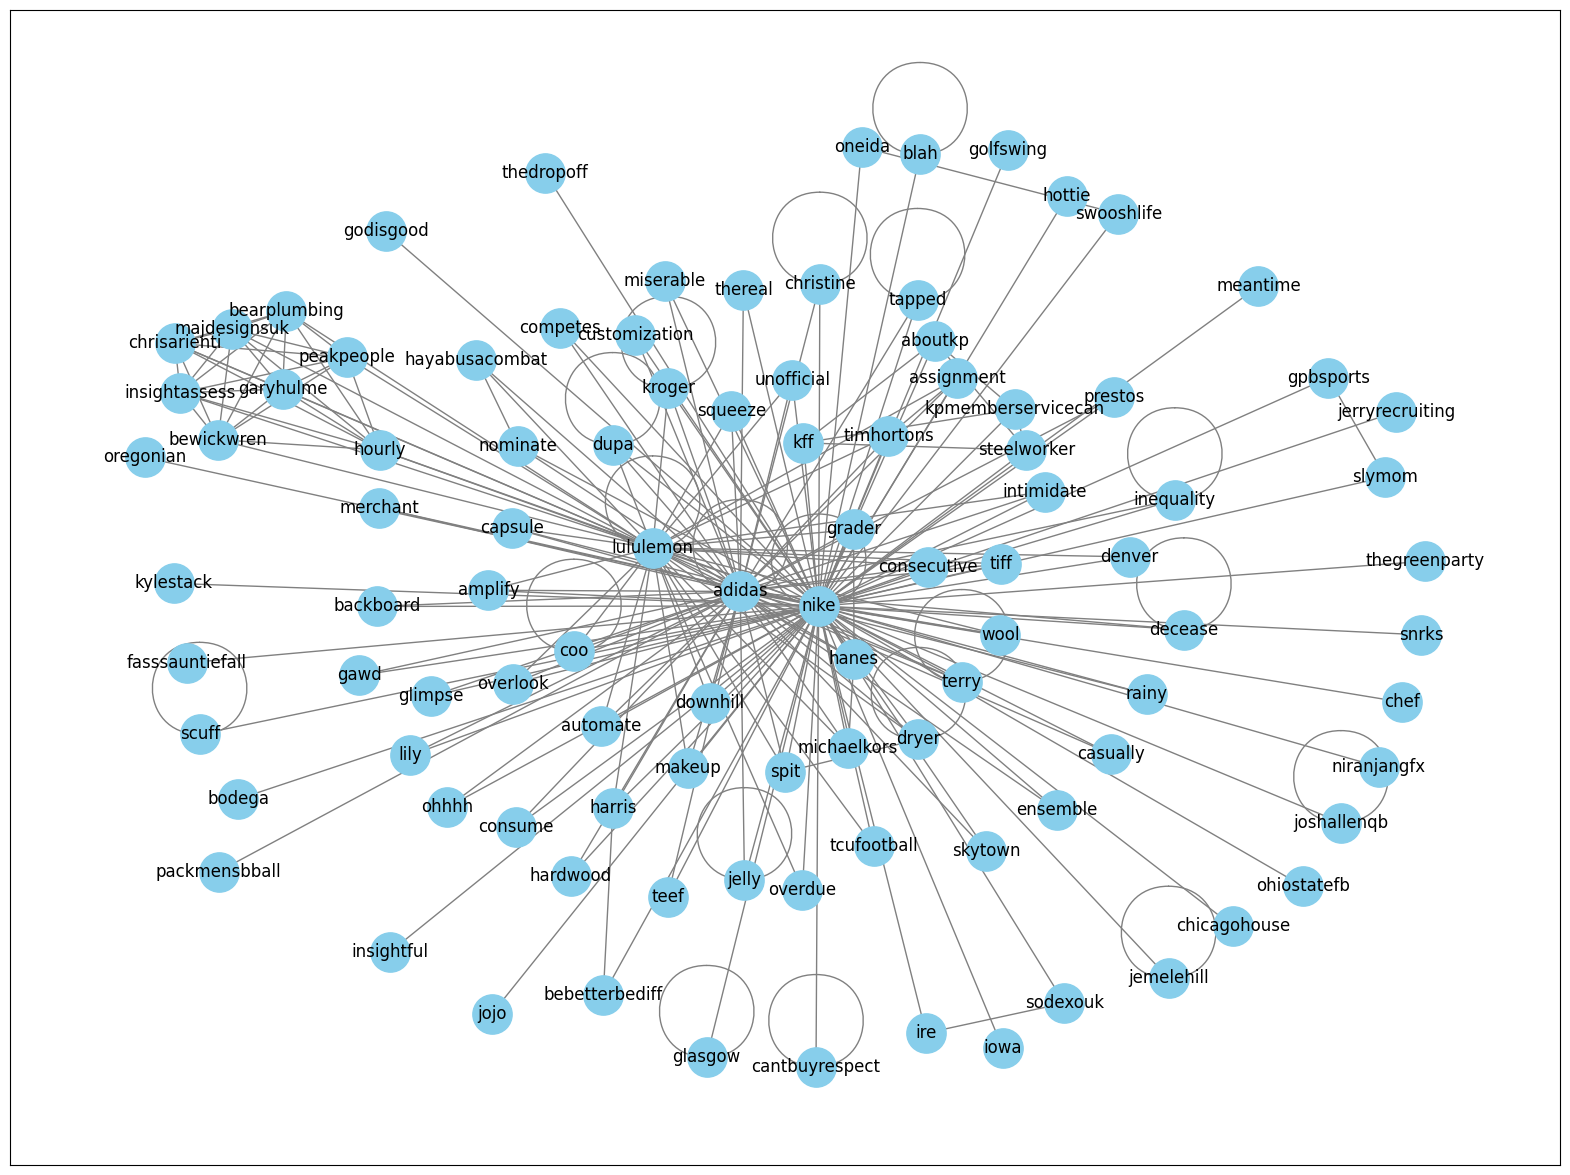

In [ ]:
draw_network_graph(graph1)

From the graph, it can be observed that Nike, Adidas, and Lululemon are all positioned at the center of the network, indicating that these comments are focused on these three brands, which aligns with our expectations.

Although there are some meaningful words in the diagram, such as "consume," "customization," and "makeup," most of the terms are usernames that were mentioned. Therefore, the next two graph was generated with the comments where mentions or hashtags were removed.

### Network nltk 2

- remove url
- **remove mentions**
- keep only letters
- lemmatize
- remove stopwords
- **filter by threshold**
- select top 100 words

In [ ]:
tweets2, words2 = process_texts(tweets, brands, sws,
                                remove_mentions=True, num_top_words=100)

In [ ]:
graph2 = build_graph(tweets2, words2)

Graph has 100 nodes and 239 edges.


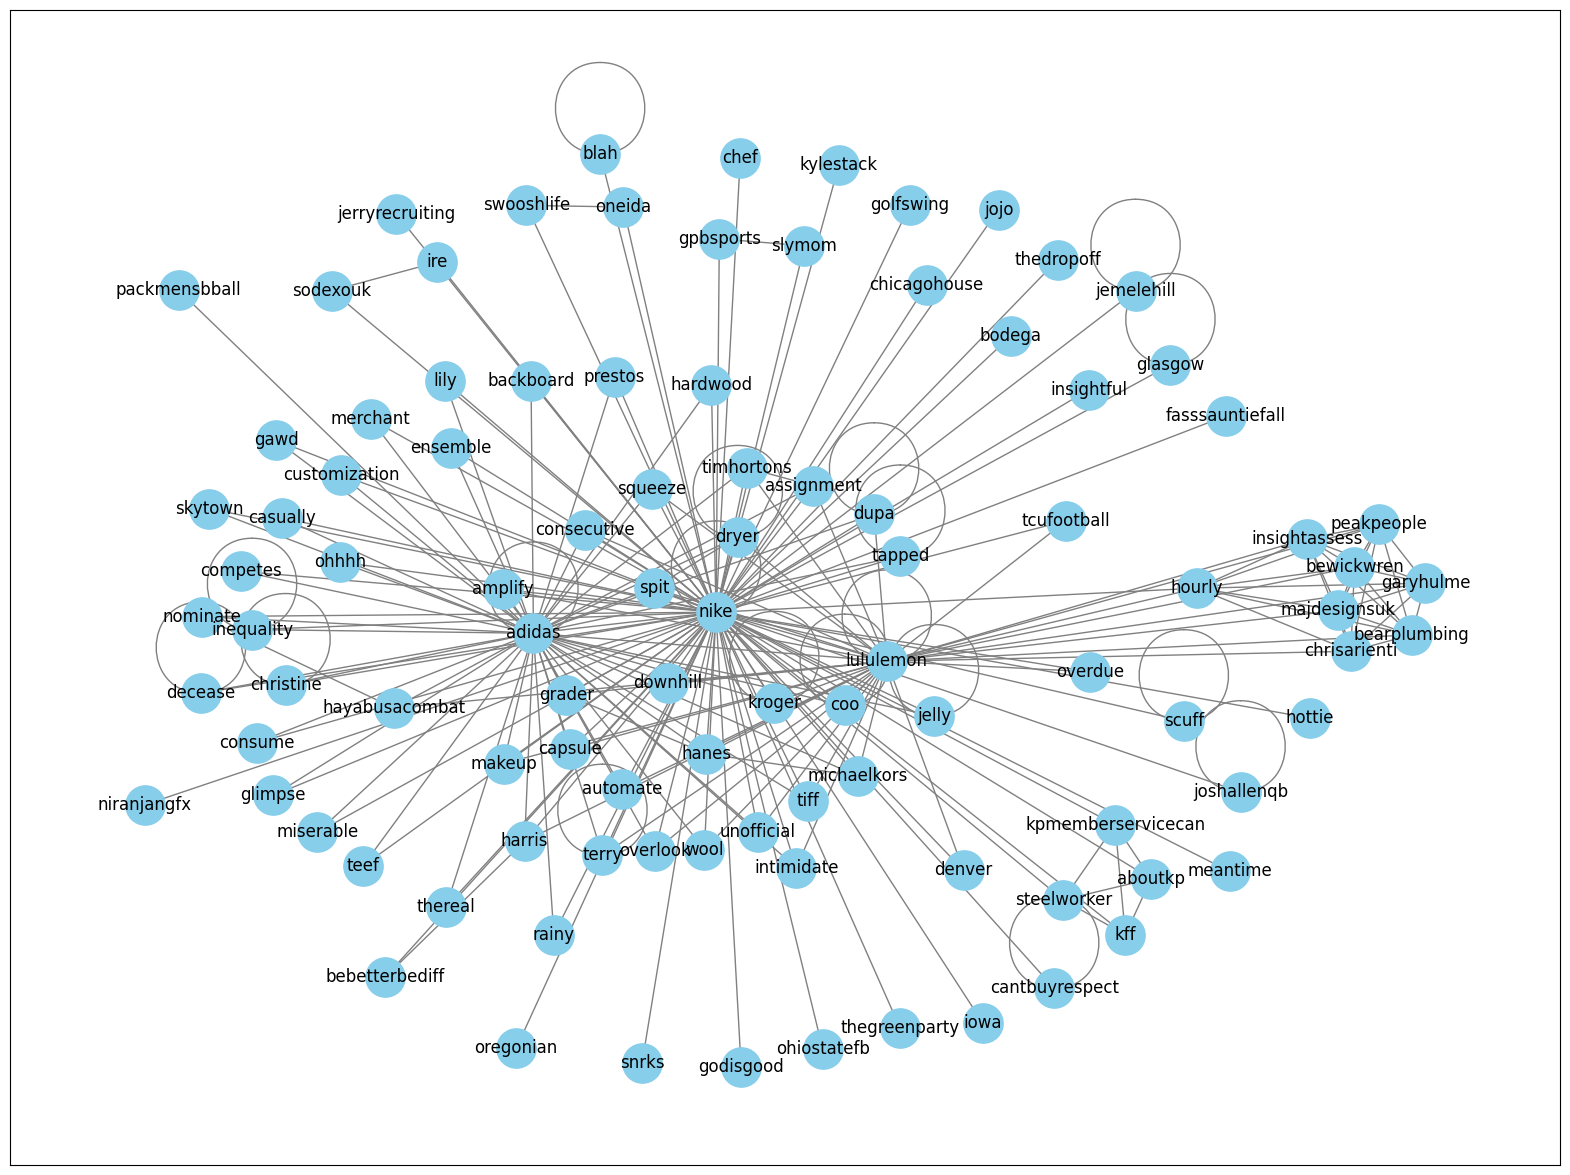

In [ ]:
draw_network_graph(graph2)

### Network nltk 3

- remove url
- **remove mentions and hashtags**
- keep only letters
- lemmatize
- remove stopwords
- **filter by threshold**
- select top 100 words

In [ ]:
tweets3, words3 = process_texts(tweets, brands, sws, True, True, 100)

In [ ]:
graph3 = build_graph(tweets3, words3)

Graph has 93 nodes and 170 edges.


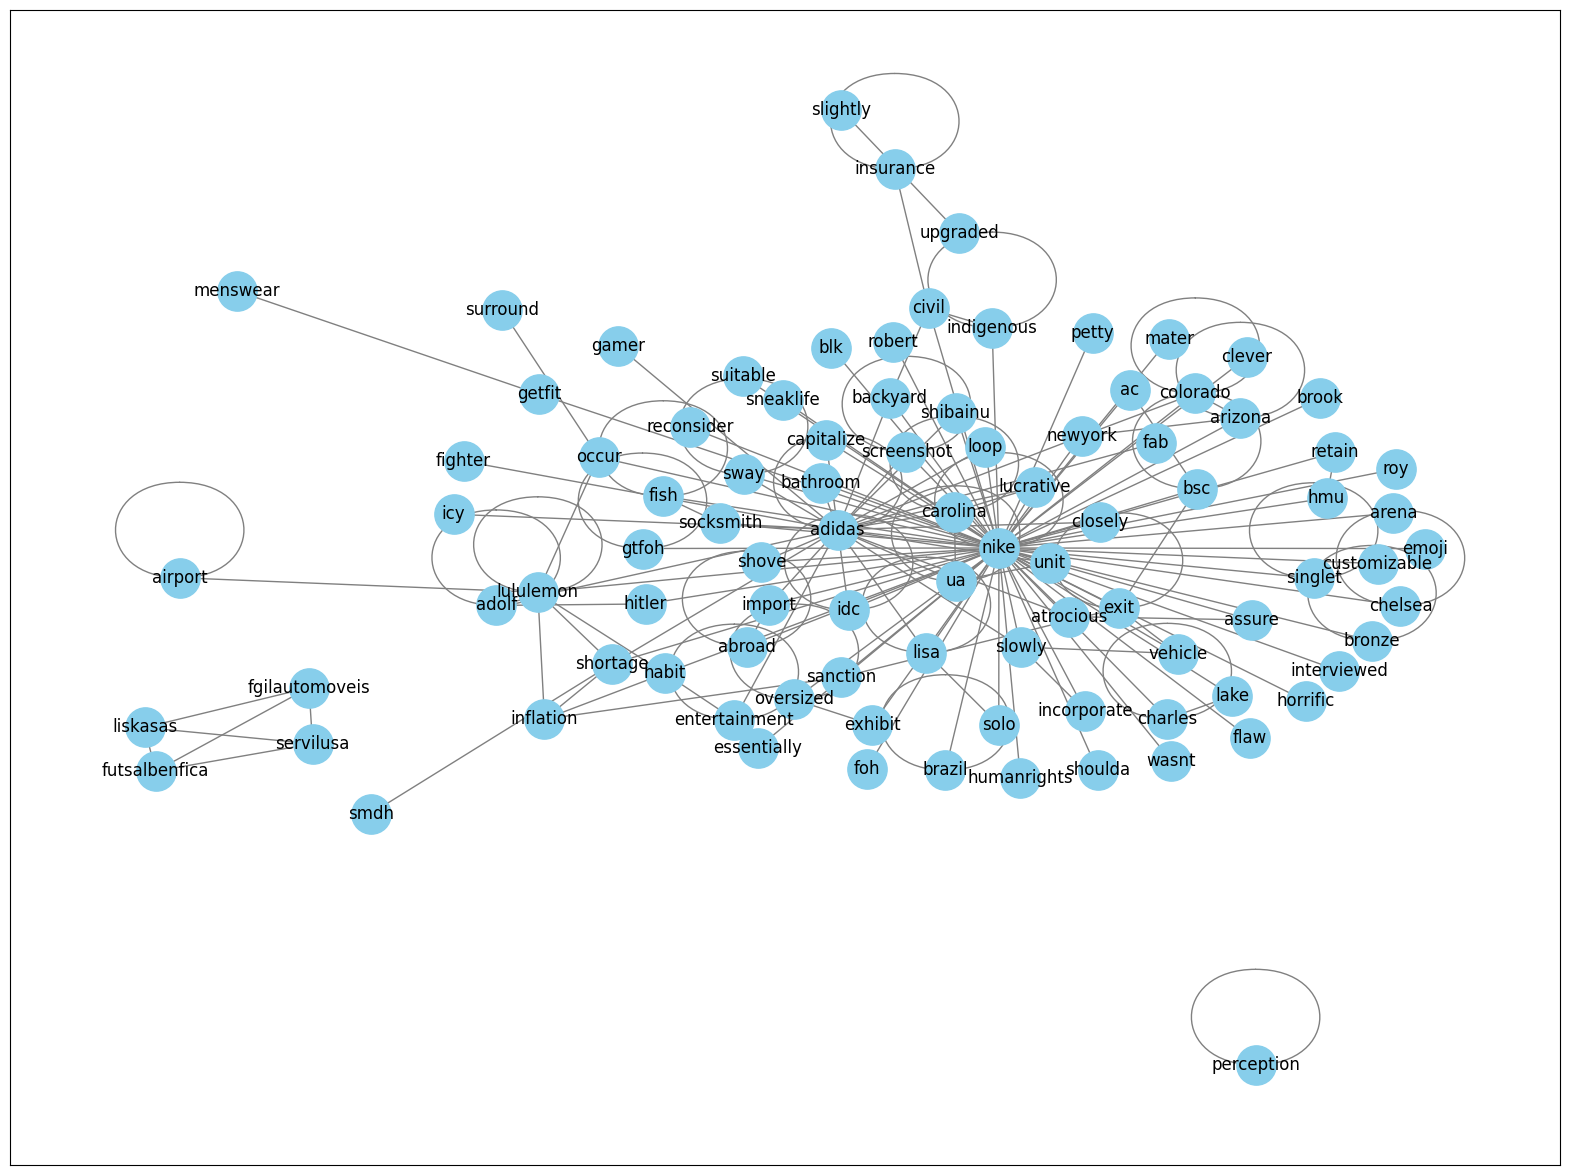

In [ ]:
draw_network_graph(graph3)

Nike and adidas, are in the central position of the graph, but lululemon is comparatively less central. Words associated with lululemon such as inflation, airport, shortage, icy, habit, entertainment, etc., can be categorized as a popular sports brand that is practical for leisure use.

Words linked to adidas like import abroad and capitalize indicate its active participation in international trade and market expansion, while words like gamer, entertainment, and screenshot may relate to digital entertainment and social media promotion. The terms backyard and bathroom suggest its involvement in home life products. This classifies adidas as an international, diversified brand deeply integrated into everyday life.

The words associated with Nike are very similar to those of adidas, but include additional terms like lucrative, customizable, arena, assure, incorporate, human rights, indigenous, and several American place names like New York. This can suggest that Nike may be perceived as more professional and trustworthy, relatively upscale, and particularly active in the US.

## Bridge Words

In [ ]:
processed_tweets, filtered_words = process_texts(tweets, brands, sws, True, True)

tokens_lst = list(processed_tweets.values())
filtered_tokens_lst = [[w for w in ts if w in filtered_words] for ts in tokens_lst]

In [ ]:
def find_bridge_words(tokens_list, brands):
    brand_co = {brand: defaultdict(int) for brand in brands}
    for tokens in tokens_list:
        token_set = set(tokens)
        for brand in brands:
            if brand in token_set:
                for word in token_set:
                    if word != brand:
                        brand_co[brand][word] += 1

    bw = set.intersection(*(set(brand_co[b].keys()) for b in brands))
    min_common_counts = {w: min(brand_co[b][w] for b in brands) for w in bw}
    return sorted(min_common_counts.items(), key=lambda x: x[1], reverse=True)


In [ ]:
bws = find_bridge_words(filtered_tokens_lst, brands)
print(f'There are {len(bws)} bridge words between {brands}')
print(bws)

There are 18 bridge words between ['nike', 'adidas', 'lululemon']
[('supplychain', 1), ('shopper', 1), ('autumn', 1), ('quantity', 1), ('spy', 1), ('clearance', 1), ('columbia', 1), ('intimidate', 1), ('calvin', 1), ('counter', 1), ('practically', 1), ('swipe', 1), ('manhattan', 1), ('usps', 1), ('shortage', 1), ('profitable', 1), ('participant', 1), ('infringe', 1)]


In [ ]:
bws

[('supplychain', 1),
 ('shopper', 1),
 ('autumn', 1),
 ('quantity', 1),
 ('spy', 1),
 ('clearance', 1),
 ('columbia', 1),
 ('intimidate', 1),
 ('calvin', 1),
 ('counter', 1),
 ('practically', 1),
 ('swipe', 1),
 ('manhattan', 1),
 ('usps', 1),
 ('shortage', 1),
 ('profitable', 1),
 ('participant', 1),
 ('infringe', 1)]